In [33]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [58]:
# read dataset
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df_zillow = pd.read_csv(f).fillna(0)

with open('../data/laucnty17.xlsx', 'rb') as f:
    df_labor = pd.read_excel(f, skiprows=range(1, 6)).fillna(0)

# restructure labor columnss
df_labor = pd.DataFrame(df_labor.iloc[:, [3,9]])
df_labor.columns = ['Location', 'Unemployment']
df_labor[['CountyName', 'State']] = df_labor['Location'].str.split(',', expand=True)
df_labor.drop(['Location'], axis=1, inplace=True)

# convert non-timeseries
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
df_zillow[['RegionID', 'RegionName', 'SizeRank']] = df_zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)
df_labor[['CountyName', 'State']] = df_labor[['CountyName', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

# remove redudant suffix
df_labor[['CountyName']] = df_labor['CountyName'].str.rstrip('county').map(lambda x: x.strip())

In [61]:
# merge dataframes
df = pd.merge(df_zillow, df_labor, on=['CountyName', 'State'])

# remove rows with unemployment >= 4.5%
df = df[df.Unemployment < 4.5]

# remove Unemployment column
df.drop(['Unemployment'], axis=1, inplace=True)

In [62]:
# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

In [63]:
#
# metro areas: these values didn't get filtered based on
#     unemployment, and likely better placed above the
#     corresponding logic.
#
hot_springs = df.loc[(df['Metro'] == 'hot springs') & (df['State'] == 'ar')]
little_rock = df.loc[(df['Metro'] == 'little rock') & (df['State'] == 'ar')]
fayetteville = df.loc[(df['Metro'] == 'fayetteville') & (df['State'] == 'ar')]
searcy = df.loc[(df['Metro'] == 'searcy') & (df['State'] == 'ar')]

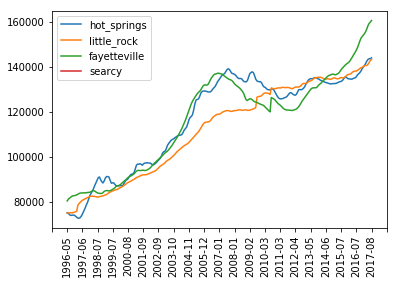

In [64]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [65]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [66]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [67]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan).dropna(
    axis=0,
    how='any',
    subset=date_columns
)

In [68]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1940.787
Method:                       css-mle   S.D. of innovations            810.924
Date:                Sat, 17 Nov 2018   AIC                           3895.575
Time:                        20:55:43   BIC                           3919.910
Sample:                    02-01-1997   HQIC                          3905.381
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        802.1669    633.471      1.266      0.207    -439.413    2043.747
ar.L1.D.y      0.4387      0.064      6.820      0.000       0.313       0.565
ar.L2.D.y      0.1861      0.070      2.655      0.0

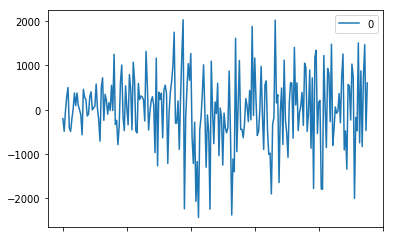

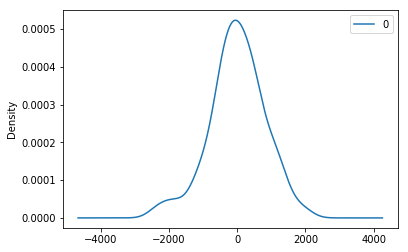

In [69]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [70]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean      3.407724
std     812.811333
min   -2429.640696
25%    -470.233762
50%      -0.179098
75%     535.442707
max    2029.306472


In [71]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=308272.595036, expected=310150.000000
prediction difference: 0.006053

predicted=308272.595036

date: 2017-3
-----------------------------------------------
predicted=309973.688180, expected=310900.000000
prediction difference: 0.002979

predicted=309973.688180

date: 2017-4
-----------------------------------------------
predicted=311686.680627, expected=311650.000000
prediction difference: 0.000118

predicted=311686.680627

date: 2017-5
-----------------------------------------------
predicted=313313.891631, expected=312250.000000
prediction difference: 0.003407

predicted=313313.891631

date: 2017-6
-----------------------------------------------
predicted=314945.463063, expected=313450.000000
prediction difference: 0.004771

predicted=314945.463063

date: 2017-7
-----------------------------------------------
predicted=316533.372322, expected=314950.000000
prediction difference: 0.005027

predicted=316533.37232

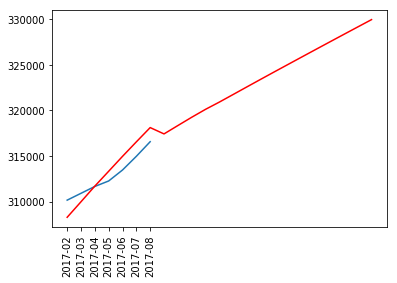

In [72]:
# plot rolling prediction
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

In [73]:
# stationarity test
def difference(dataset, delta):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - delta]
        diff.append(value)
    return pd.Series(diff)

def compute_arima(df_train):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in df_train]
    predictions = list()
    iterations = (12-len(df_test)) + 18

    for t in range(iterations):
        #
        # determine stationarity value: no need to difference more than
        #     half the lenght of the given series.
        #
        # @delta, the difference factor.
        #
        for delta in range(int(len(history) / 2)):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            autoreg = delta
            print('delta: {}, p: {}'.format(delta, result[1]))

            #
            # generate model: use dickey-fuller significance test using
            #     custom 'difference' function. Sometimes, statsmodels
            #     arima algorithm will not agree with our pvalue, so it
            #     is forced to search for another significant difference.
            #
            if (result[1] <= 0.05):
                try:
                    model = ARIMA(history, order=(autoreg, 2, 2))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('stationarity not adequate')
                    continue

        output = model_fit.forecast()
        yhat = output[0]

        #
        # observation: if current value doesn't exist from test, append current
        #     predition, to ensure successive rolling prediction computed.
        #
        try:
            obs = df_test[t]
        except:
            obs = yhat
        history.append(obs)
        
        predictions.append(yhat)
        print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [74]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

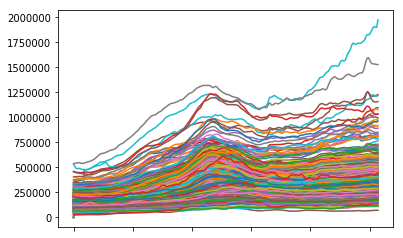

In [75]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [ ]:
## iterate columns
results = []
for column in df_zipcode_clean:
    predictions = compute_arima(df_zipcode_clean[column])
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


delta: 0, p: nan
delta: 1, p: 0.43581480343739437
delta: 2, p: 0.09602268561265981
delta: 3, p: 0.12330830782157487
delta: 4, p: 0.13016438413596815
delta: 5, p: 0.10373052767375313
delta: 6, p: 0.1603877865387051
delta: 7, p: 0.042705747735187594
predictions: [array([343970.13104049])]
delta: 0, p: nan
delta: 1, p: 0.09381673911196603
delta: 2, p: 0.18711215866698
delta: 3, p: 0.4796457193182296
delta: 4, p: 0.23249340859715173
delta: 5, p: 0.49051229252979034
delta: 6, p: 2.5012945723098646e-30
predictions: [array([343970.13104049]), array([261967.24648193])]
delta: 0, p: nan
delta: 1, p: 0.021538220389332563
predictions: [array([343970.13104049]), array([261967.24648193]), array([311449.67031637])]
delta: 0, p: nan
delta: 1, p: 0.009131747154693998
predictions: [array([343970.13104049]), array([261967.24648193]), array([311449.67031637]), array([310335.32397835])]
delta: 0, p: nan
delta: 1, p: 4.4362900385969485e-21
predictions: [array([343970.13104049]), array([261967.24648193]), a

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:207: RuntimeWarning: invalid value encountered in greater
  if teststat > maxstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:209: RuntimeWarning: invalid value encountered in less
  elif teststat < minstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:211: RuntimeWarning: invalid value encountered in less_equal
  if teststat <= starstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal


delta: 0, p: [nan]
delta: 1, p: [2.79493533e-21]
predictions: [array([343970.13104049]), array([261967.24648193]), array([311449.67031637]), array([310335.32397835]), array([311539.35444611]), array([312992.83626615]), array([314704.42000548]), array([316460.61482563]), array([315997.13600627])]
delta: 0, p: [nan]
delta: 1, p: [2.57060222e-21]
predictions: [array([343970.13104049]), array([261967.24648193]), array([311449.67031637]), array([310335.32397835]), array([311539.35444611]), array([312992.83626615]), array([314704.42000548]), array([316460.61482563]), array([315997.13600627]), array([315504.63877454])]
delta: 0, p: [nan]
delta: 1, p: [2.35769689e-21]
predictions: [array([343970.13104049]), array([261967.24648193]), array([311449.67031637]), array([310335.32397835]), array([311539.35444611]), array([312992.83626615]), array([314704.42000548]), array([316460.61482563]), array([315997.13600627]), array([315504.63877454]), array([315004.9728108])]
delta: 0, p: [nan]
delta: 1, p: 